In [1]:
import os, csv, sys
import io, textwrap, itertools
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
csv.field_size_limit(sys.maxsize)

common_amino_acid_set = {
    'R', 'X', 'S', 'G', 'W', 'I', 'Q', 'A', 'T', 'V', 'K', 'Y', 'C', 'N', 'L', 'F', 'D', 'M', 'P', 'H', 'E'
}


def clean_seq(protein_id, seq):
    seq = seq.upper()
    new_seq = ""
    has_invalid_char = False
    invalid_char_set = set()
    for ch in seq:
        if 'A' <= ch <= 'Z' and ch not in ['J']:
            new_seq += ch
        else:
            invalid_char_set.add(ch)
            has_invalid_char = True
    if has_invalid_char:
        print("id: %s. Seq: %s" % (protein_id, seq))
        print("invalid char set:", invalid_char_set)
    return new_seq


def file_reader(filename, header=True, header_filter=True):
    if filename.endswith(".fa") or filename.endswith(".fas") or filename.endswith(".fasta"):
        return fasta_reader(filename)
    elif filename.endswith(".csv"):
        return csv_reader(filename, header=True, header_filter=True)
    elif filename.endswith(".tsv"):
        return tsv_reader(filename, header=True, header_filter=True)
    else:
        return txt_reader(filename, header=header, header_filter=header_filter)


def txt_reader(handle, header=True, header_filter=True):
    '''
    csv 读取器，适合大文件
    :param handle:
    :param header:
    :param header_filter: 返回结果是否去掉头
    :return:
    '''
    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'r')
    try:
        cnt = 0
        for line in handle:
            cnt += 1
            if header and header_filter and cnt == 1:
                continue
            yield line.strip()
    except Exception as e:
        raise StopIteration
    finally:
        if not handle.closed:
            handle.close()


def tsv_reader(handle, header=True, header_filter=True):
    '''
    csv 读取器，适合大文件
    :param handle:
    :param header:
    :param header_filter: 返回结果是否去掉头
    :return:
    '''
    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'r')
    try:
        reader = csv.reader(handle, delimiter="\t")
        cnt = 0
        for row in reader:
            cnt += 1
            if header and header_filter and cnt == 1:
                continue
            yield row
    except Exception as e:
        raise StopIteration
    finally:
        if not handle.closed:
            handle.close()


def csv_reader(handle, header=True, header_filter=True):
    '''
    csv 读取器，适合大文件
    :param handle:
    :param header:
    :param header_filter: 返回结果是否去掉头
    :return:
    '''
    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'r')
    try:
        # data = csv.reader((line.replace('\0','') for line in data_initial), delimiter=",")
        # reader = csv.reader(handle)
        reader = csv.reader((line.replace('\0', '') for line in handle))
        cnt = 0
        for row in reader:
            cnt += 1
            if header and header_filter and cnt == 1:
                continue
            yield row
    except Exception as e:
        raise StopIteration
    finally:
        if not handle.closed:
            handle.close()


def txt_writer(dataset, handle, header=None):
    '''
    txt 写
    :param dataset: 数据
    :param handle: 文件
    :param header: 头
    :return:
    '''
    with open(handle, "w") as wfp:
        if header:
            if isinstance(header, list):
                wfp.write(",".join(header) + "\n")
            else:
                wfp.write(header + "\n")
        for row in dataset:
            wfp.write(str(row) + "\n")


def csv_writer(dataset, handle, header):
    '''
    csv 写，适合大文件
    :param dataset: 数据
    :param handle: 文件
    :param header: 头
    :return:
    '''
    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'w')
    try:
        writer = csv.writer(handle)
        if header:
            writer.writerow(header)
        for row in dataset:
            writer.writerow(row)
    except Exception as e:
        raise e
    finally:
        if not handle.closed:
            handle.close()


def tsv_writer(dataset, handle, header):
    '''
    tsv 写，适合大文件
    :param dataset: 数据
    :param handle: 文件
    :param header: 头
    :return:
    '''
    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'w')
    try:
        writer = csv.writer(handle, delimiter="\t")
        if header:
            writer.writerow(header)
        for row in dataset:
            writer.writerow(row)
    except Exception as e:
        raise e
    finally:
        if not handle.closed:
            handle.close()


def fasta_reader(handle, width=None):
    """
    Reads a FASTA file, yielding header, sequence pairs for each sequence recovered 适合大文件
    args:
        :handle (str, pathliob.Path, or file pointer) - fasta to read from
        :width (int or None) - formats the sequence to have max `width` character per line.
                               If <= 0, processed as None. If None, there is no max width.
    yields:
        :(header, sequence) tuples
    returns:
        :None
    """
    FASTA_STOP_CODON = "*"

    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'r')
    width = width if isinstance(width, int) and width > 0 else None
    try:
        header = None
        for is_header, group in itertools.groupby(handle, lambda line: line.startswith(">")):
            if is_header:
                header = group.__next__().strip()
            else:
                seq = ''.join(line.strip() for line in group).strip().rstrip(FASTA_STOP_CODON)
                if width is not None:
                    seq = textwrap.fill(seq, width)
                yield header, seq
    except Exception as e:
        raise StopIteration
    finally:
        if not handle.closed:
            handle.close()


def write_fasta(filepath, sequences):
    '''
    write fasta file
    :param filepath: savepath
    :param sequences: fasta sequence(each item: [id, seq])
    :return:
    '''

    if sequences:
        with open(filepath, "w") as output_handle:
            if len(sequences[0]) > 1 and isinstance(sequences[0][0], str):
                for row in sequences:
                    protein_id = row[0]
                    seq = row[1]
                    sequence = SeqRecord(Seq(seq, None), id=protein_id[1:] if protein_id and protein_id[0] == ">" else protein_id, description="")
                    SeqIO.write(sequence, output_handle, "fasta")
            else:
                for sequence in sequences:
                    SeqIO.write(sequence, output_handle, "fasta")

In [2]:
label_filepath = "./lucapcycle_v3_31_classes_confusion_matrix/dataset/label.txt"
label_name_list = []
for row in csv_reader(label_filepath):
    label_name_list.append(row[0])
print("label_name_list size: %d" % len(label_name_list))

ground_truth_filepath_list = [
    "./lucapcycle_v3_31_classes_confusion_matrix/dataset/dev.csv", 
    "./lucapcycle_v3_31_classes_confusion_matrix/dataset/test.csv"
]
ground_truth = {}
ground_truth_list = []
for ground_truth_filepath in ground_truth_filepath_list:
    for row in csv_reader(ground_truth_filepath):
        seq_id = row[0]
        label_idx = int(row[3])
        label_name = label_name_list[label_idx]
        ground_truth[seq_id] = label_name
        ground_truth_list.append(label_idx)
print("ground_truth: %d" % len(ground_truth))

predicted_filepath_list = [
    "./lucapcycle_v3_31_classes_confusion_matrix/predicted_results/dev_for_v3_20240923094428_8569250_10.csv",
    "./lucapcycle_v3_31_classes_confusion_matrix/predicted_results/test_for_v3_20240923094428_8569250_10.csv"
]
predicted = {}
predicted_list = []
for predicted_filepath in predicted_filepath_list:
    for row in csv_reader(predicted_filepath):
        seq_id = row[0]
        label_name = row[3]
        predicted[seq_id] = label_name
        predicted_list.append(label_name_list.index(label_name))
print("predicted: %d" % len(predicted))

label_name_list size: 31
ground_truth: 42808
predicted: 42808


y_true: 42808
y_pred: 42808


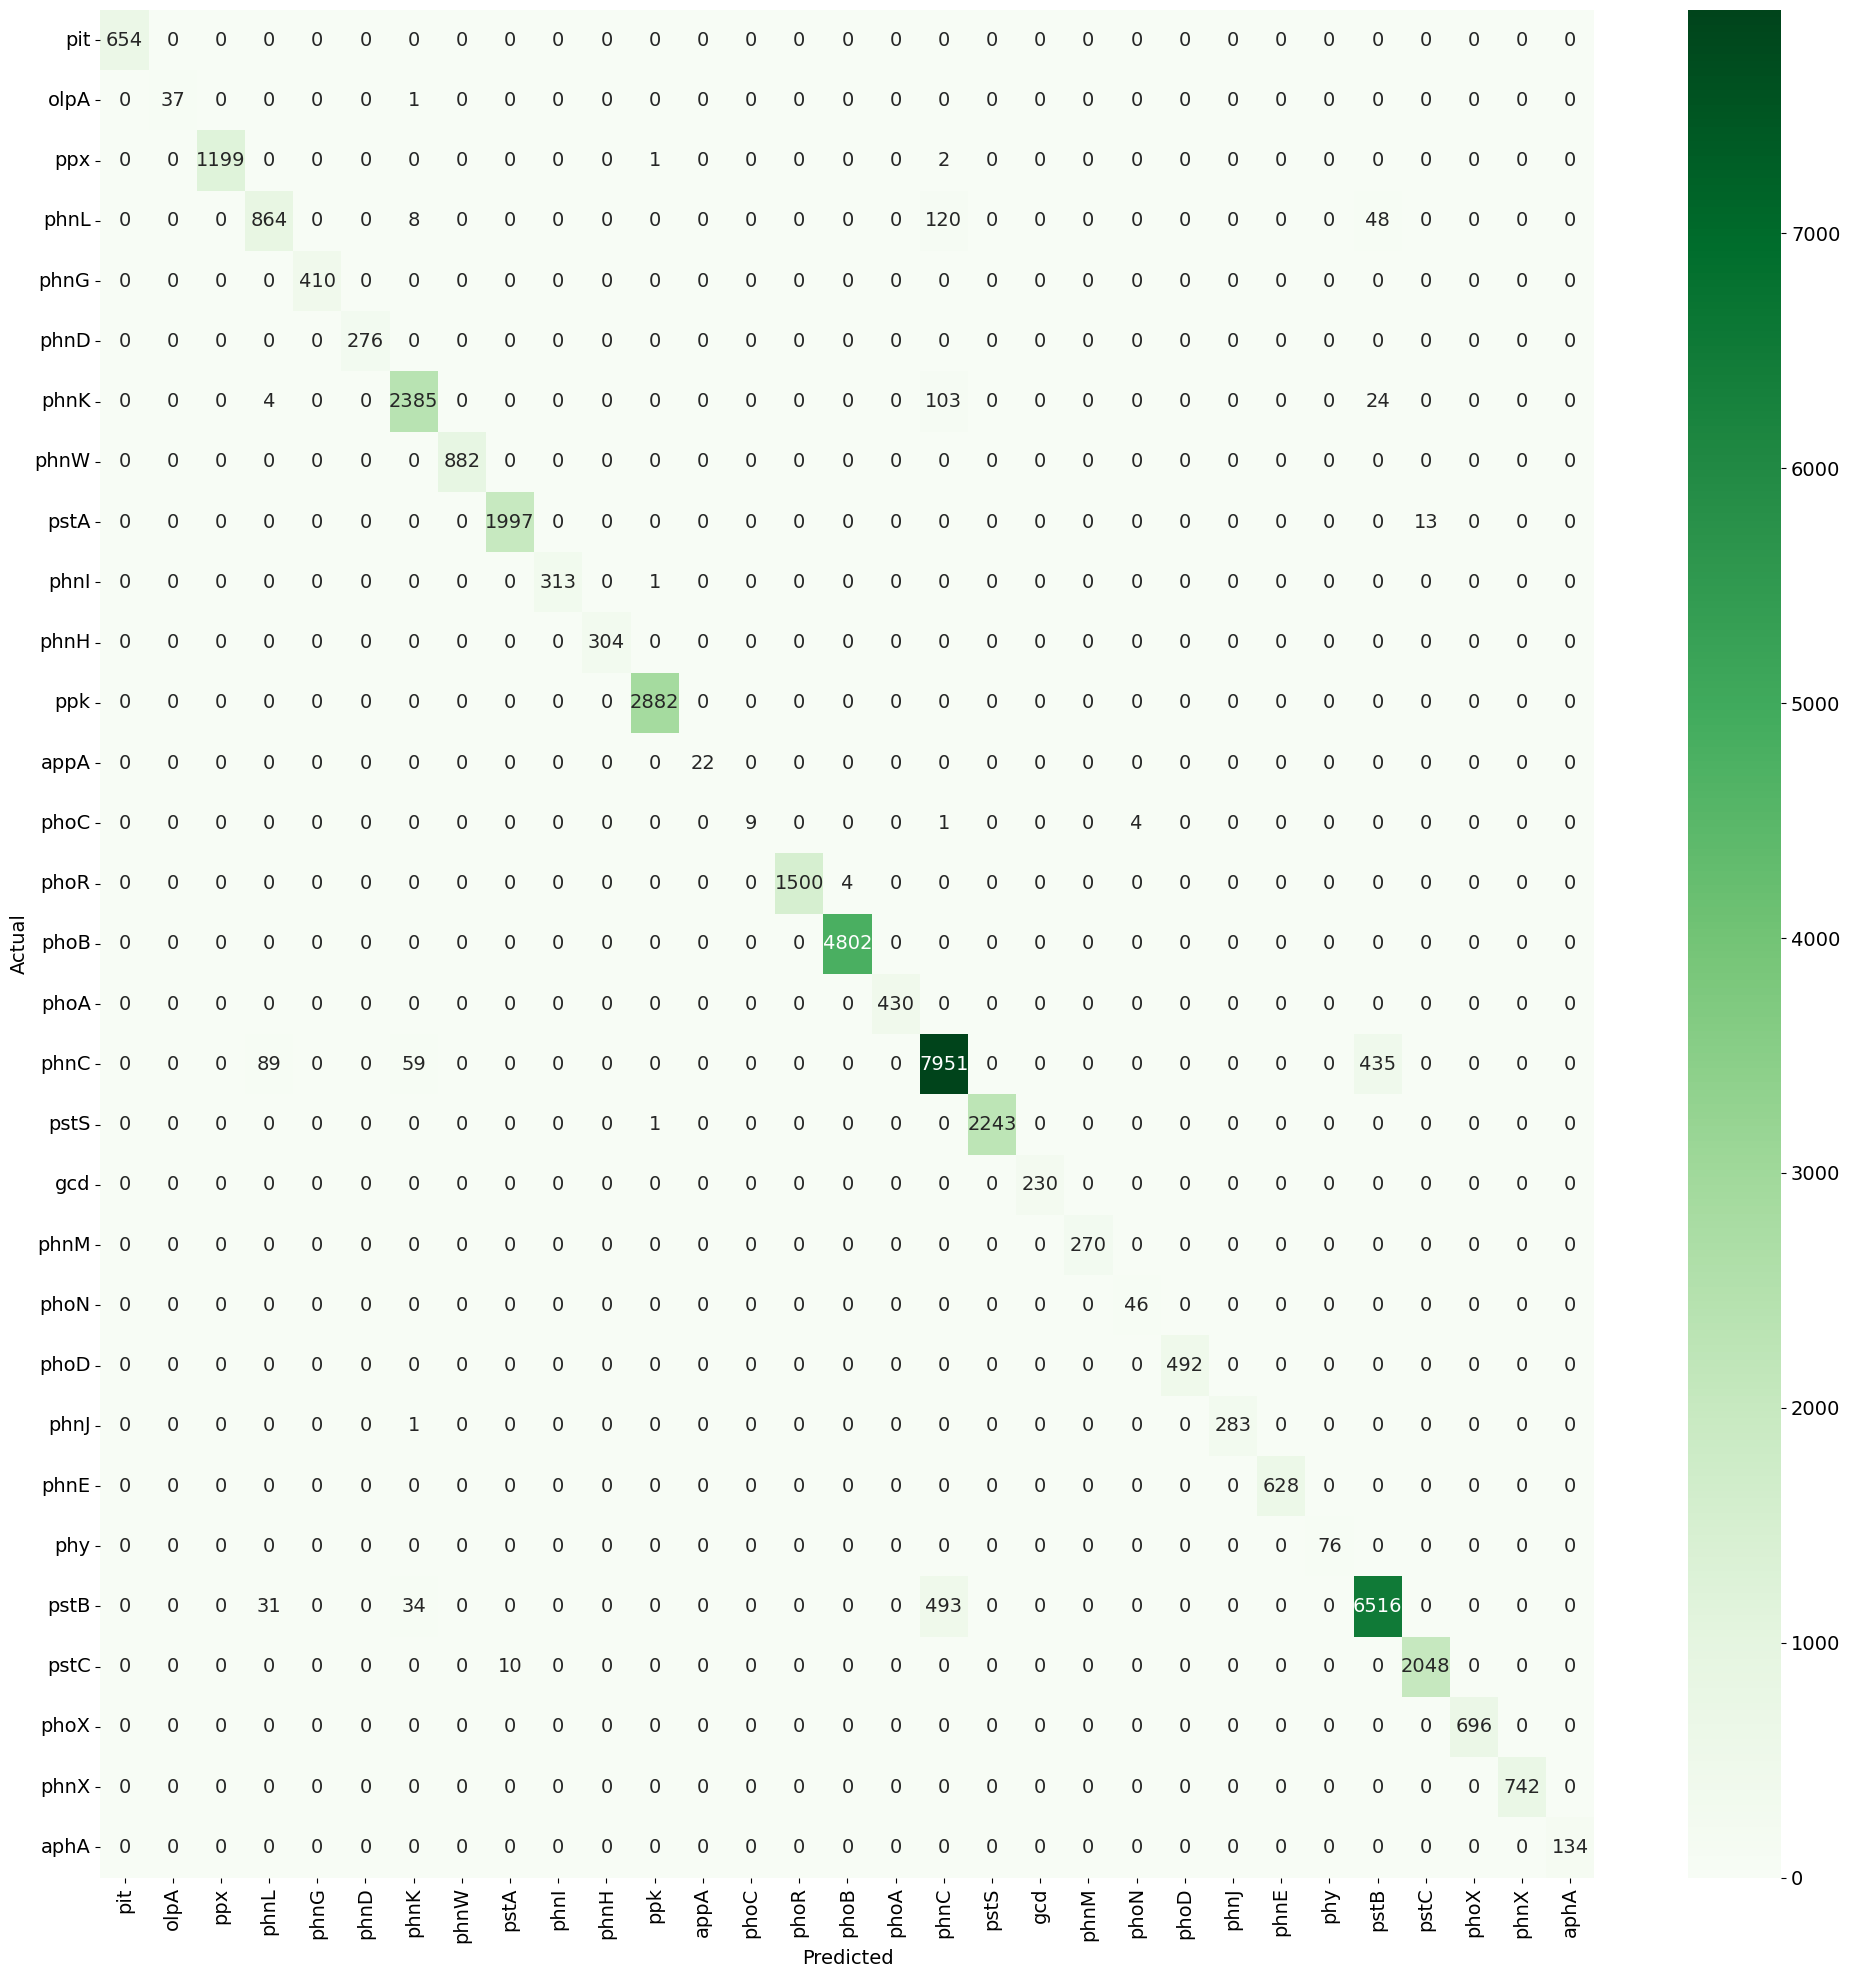

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.rcParams['font.size'] = 14

# 进行预测
y_true = ground_truth_list
y_pred = predicted_list
print("y_true: %d" % len(y_true))
print("y_pred: %d" % len(y_pred))

# 生成混淆矩阵
cm = confusion_matrix(y_true, y_pred)

# 转换为DataFrame以便可视化
cm_df = pd.DataFrame(cm, index=label_name_list, columns=label_name_list)

# 绘制混淆矩阵
plt.figure(figsize=(20, 20))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Greens')
# plt.title('Confusion Matrix on Validation and Testing', fontsize=12)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()  # 调整布局防止重叠
# 显示图形
plt.savefig("./pic/fig.lucapcycle_31_classification_metrics_confusion_matrix_validation_testing.png", dpi=600,  format='png')
plt.savefig("./pic/fig.lucapcycle_31_classification_metrics_confusion_matrix_validation_testing.pdf", dpi=600,  format='pdf')

In [4]:
ground_truth_label_stats = {}
for label_idx in ground_truth_list:
    label_name = label_name_list[label_idx]
    if label_name not in ground_truth_label_stats:
        ground_truth_label_stats[label_name] = 1
    else:
        ground_truth_label_stats[label_name] +=1


err_pairs = {}
right_pairs = {}
for idx, y_t in enumerate(y_true):
    y_t_name = label_name_list[y_t]
    y_p = y_pred[idx]
    y_p_name = label_name_list[y_p]
    if y_t != y_p:
        if y_t_name not in err_pairs:
            err_pairs[y_t_name] = {}
            err_pairs[y_t_name][y_p_name] = 1
        elif y_p_name not in err_pairs[y_t_name]:
            err_pairs[y_t_name][y_p_name] = 1
        else:
            err_pairs[y_t_name][y_p_name] += 1
    else:
        if y_t_name not in right_pairs:
            right_pairs[y_t_name] = {}
            right_pairs[y_t_name][y_p_name] = 1
        elif y_p_name not in right_pairs[y_t_name]:
            right_pairs[y_t_name][y_p_name] = 1
        else:
            right_pairs[y_t_name][y_p_name] += 1
err_pair_list = []
for item1 in err_pairs.items():
    for item2 in item1[1].items():
        err_pair_list.append(["%s->%s" % (
            item1[0], 
            item2[0]), item2[1], ground_truth_label_stats[item1[0]], item2[1]/ground_truth_label_stats[item1[0]]])
err_pair_list = sorted(err_pair_list, key=lambda x: x[1], reverse=True)
for item in err_pair_list:
    print("%s: total=%d, err_cnt=%d, err_rate=%.4f" % (item[0], item[2], item[1], item[3]))

pstB->phnC: total=7074, err_cnt=493, err_rate=0.0697
phnC->pstB: total=8534, err_cnt=435, err_rate=0.0510
phnL->phnC: total=1040, err_cnt=120, err_rate=0.1154
phnK->phnC: total=2516, err_cnt=103, err_rate=0.0409
phnC->phnL: total=8534, err_cnt=89, err_rate=0.0104
phnC->phnK: total=8534, err_cnt=59, err_rate=0.0069
phnL->pstB: total=1040, err_cnt=48, err_rate=0.0462
pstB->phnK: total=7074, err_cnt=34, err_rate=0.0048
pstB->phnL: total=7074, err_cnt=31, err_rate=0.0044
phnK->pstB: total=2516, err_cnt=24, err_rate=0.0095
pstA->pstC: total=2010, err_cnt=13, err_rate=0.0065
pstC->pstA: total=2058, err_cnt=10, err_rate=0.0049
phnL->phnK: total=1040, err_cnt=8, err_rate=0.0077
phnK->phnL: total=2516, err_cnt=4, err_rate=0.0016
phoC->phoN: total=14, err_cnt=4, err_rate=0.2857
phoR->phoB: total=1504, err_cnt=4, err_rate=0.0027
ppx->phnC: total=1202, err_cnt=2, err_rate=0.0017
ppx->ppk: total=1202, err_cnt=1, err_rate=0.0008
phnI->ppk: total=314, err_cnt=1, err_rate=0.0032
phoC->phnC: total=14, 

In [5]:
print("Less Frequent Classes:")
for item in ground_truth_label_stats.items():
    if item[1] <= 200:
        print(item[0])
        print(
            "total: %d, right: %d, acc: %d/%d=%.4f" % (
                item[1],
                right_pairs[item[0]][item[0]], 
                item[1],right_pairs[item[0]][item[0]],
                right_pairs[item[0]][item[0]]/item[1])
        )
        print("-" * 50)

Less Frequent Classes:
olpA
total: 38, right: 37, acc: 38/37=0.9737
--------------------------------------------------
appA
total: 22, right: 22, acc: 22/22=1.0000
--------------------------------------------------
phoC
total: 14, right: 9, acc: 14/9=0.6429
--------------------------------------------------
phoN
total: 46, right: 46, acc: 46/46=1.0000
--------------------------------------------------
phy
total: 76, right: 76, acc: 76/76=1.0000
--------------------------------------------------
aphA
total: 134, right: 134, acc: 134/134=1.0000
--------------------------------------------------
